<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-окружения" data-toc-modified-id="Подготовка-окружения-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка окружения</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Подготовка окружения

Загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

### Обзор данных

Загрузим данные.

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов

Выведем на экран обзорную информацию о данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


### Предобработка данных

Необходимо убедиться в корректной последовательности данных, а также ресемплировать их.

In [5]:
data.sort_index(inplace=True)

In [6]:
data = data.resample('1H').sum()

In [7]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Дальнейшая предобработка не требуется. В данных нет пустых значений они отсортированы в нужном порядке и ресемплированы. Можно переходить к анализу. Для анализа сделаем копию датасета, в которую будем добавлять необходимые переменные.

In [8]:
analysis = data.copy()

## Анализ

В первую очередь необходимо изучить график временного ряда. Изучим сперва агрегированные данные. Смотреть на график по часам за полгода бессмысленно, но если агрегировать его по дням, можно выявить тенденцию изменения данных.

<AxesSubplot:xlabel='datetime'>

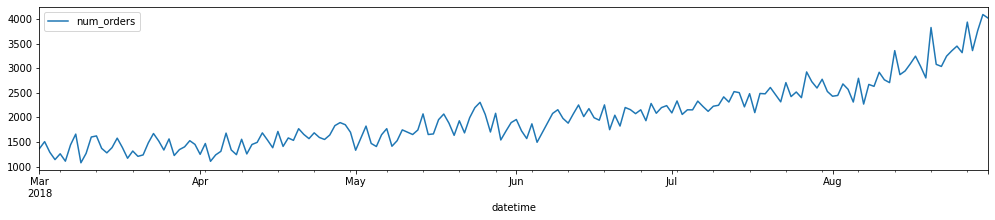

In [9]:
analysis.resample('1d').sum().plot(figsize=(17,3))

На графике очевидно прослеживается тенденция к росту количества заказов в день. Пока нельзя однозначно сказать, есть ли устойчивые колебания спроса внутри недели или месяца, поэтому необходимо это отдельно изучить.

Изучим малую часть данных - первый месяц, без агрегации. Так как необходимо строить прогноз на ближайший час - будет полезным понять, как по часам эти значения меняются в течении дня.

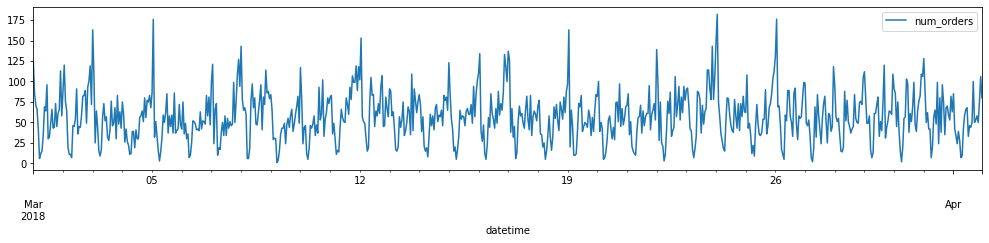

In [10]:
analysis['2018-03-01':'2018-04-01'].plot(figsize=(17,3))
plt.show()

На графике есть явно выраженная зависимость. Каждый день есть пиковые и спокойные часы. Дневные колебания находятся в определенном диапазоне и редко отклоняются от устоявшегося паттерна. Очевидных недельных и месячных колебаний не видно, однако нельзя точно сказать, что их нет.

Проанализируем скользящее среднее графика.

In [11]:
analysis['rollin_mean'] = analysis.rolling(50).mean()

<AxesSubplot:xlabel='datetime'>

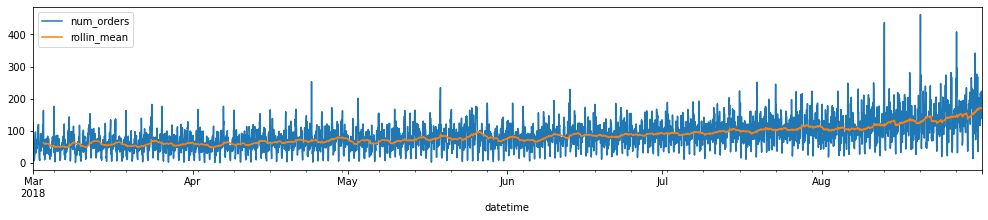

In [12]:
analysis.plot(figsize=(17,3))

Скользящее среднее подтверждает тенденцию к росту количества заказов, пусть и не такому драматическому, как при ресемплировании.

Простроим графики тренда, шума и сезонности.

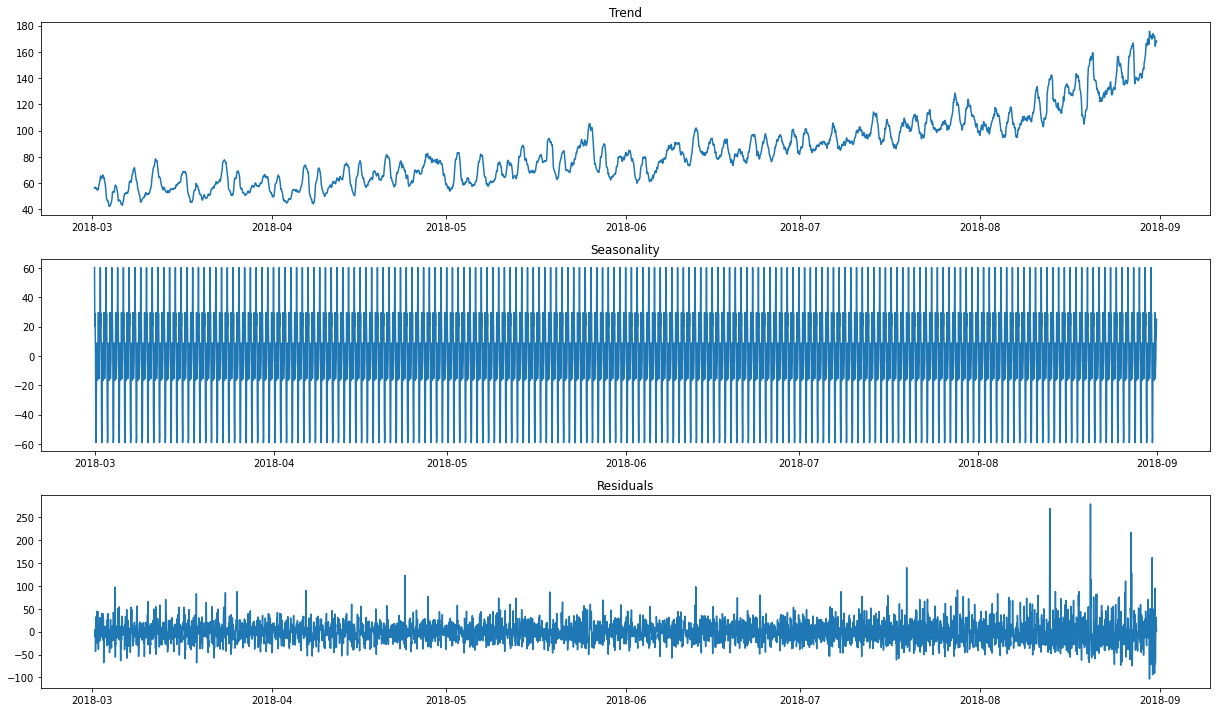

In [13]:
decomposed = seasonal_decompose(analysis['num_orders'])

fig, axs = plt.subplots(3,1,figsize=(17, 10))

axs[0].plot(decomposed.trend)
axs[0].set_title('Trend')
axs[1].plot(decomposed.seasonal)
axs[1].set_title('Seasonality')
axs[2].plot(decomposed.resid)
axs[2].set_title('Residuals')
plt.tight_layout()

Действительно, есть тенденция к повышению количества заказов, а внутри одного дня есть четко выраженные колебания спроса.

Также изучим агрегированные по дню данные, что бы выяснить, есть ли четко выраженные колебания внутри недели и месяца.

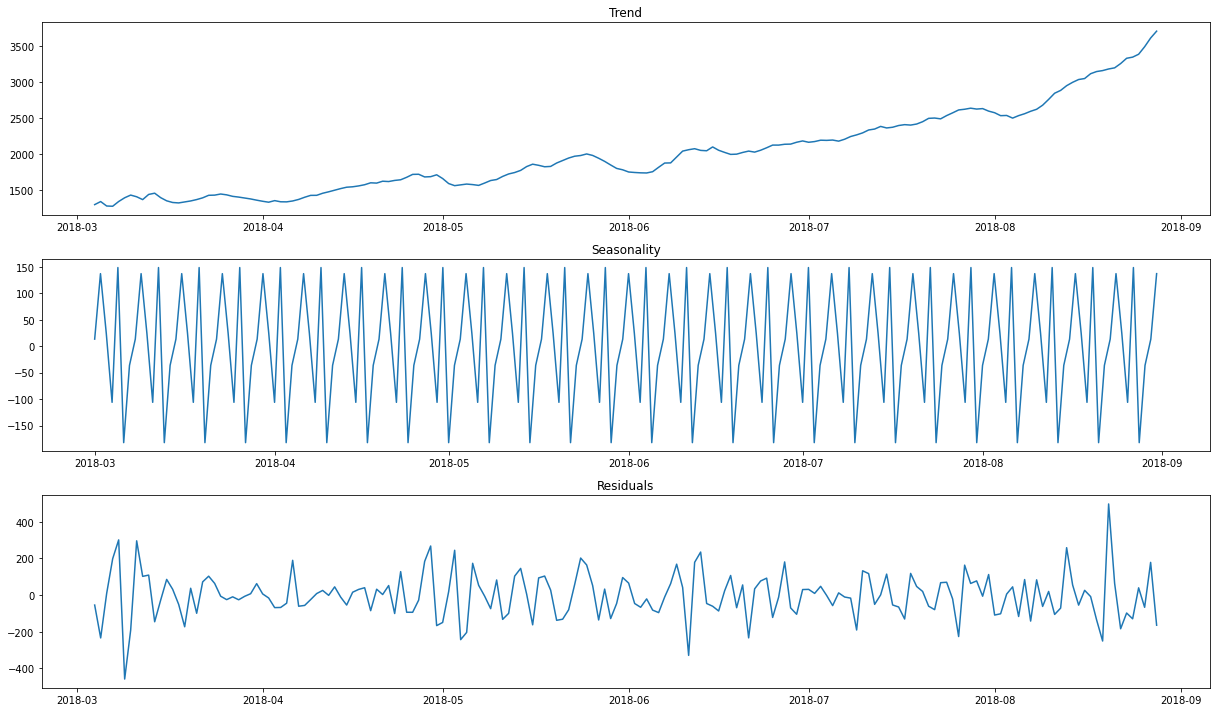

In [14]:
analysis = analysis.resample('1D').sum()

decomposed = seasonal_decompose(analysis['num_orders'])

fig, axs = plt.subplots(3,1,figsize=(17, 10))

axs[0].plot(decomposed.trend)
axs[0].set_title('Trend')
axs[1].plot(decomposed.seasonal)
axs[1].set_title('Seasonality')
axs[2].plot(decomposed.resid)
axs[2].set_title('Residuals')
plt.tight_layout()

Действительно, если смотреть на данные, агрегированные по дню, в зависимости от дня недели. спрос будет колебаться. На графике четко выражены четыре пика и четыре спада в месяц. Тренд же, почти выправился. На имеющемся масштабе данных все зависимости выделены. При наличии данных за год-два, можно было бы сказать что-то о сезонности внутригодовой, так как ожидается, что осенью и в начале зимы должен происходить рост количества заказов такси.

По результатам анализа данных можно сделать следующие выводы:

1. В данных есть четкие, стабильные колебания в рамках одного дня и в рамках одной недели. Необходимо для более точного прогнозирования добавить в данные временные значения - час и день недели.
2. Наблюдается растущий тренд и в отсутствии возможности проверить, является ли этот тренд следствием внутригодовой сезонности, учитывать его корректнее через сдвиг в данных. Сдвиг будем учитывать в масштабе часа - возьмем этот же час предыдущих суток и суток перед ними. Это позволит исключить влияние дневных колебаний и искажение из-за них.
3. Скользящее среднее показательно в рамках определения общей тенденции ряда. Используем также его в качестве признака. Скользящее среднее добавим за предыдущие двое суток.

## Обучение

Перед обучением моделей подготовим данные. Напишем функцию, добавляющую временные параметры, сдвиг и скользящее среднее.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    for i in range(1, max_lag+1):
        data[f'lag_{i}'] = data['num_orders'].shift(i*24)
    data['rollin_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data

Применим преобразования к нашим данным и сохраним в новую переменную.

In [16]:
ml_data = make_features(data.copy(), 2, 48)

Разобъем данные на тестовую и тренировочную выборки. Для тестовой выборки возьмем 10% данных.

In [17]:
train, test = train_test_split(ml_data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

Обучим первую, самую простую модель линейной регрессии.

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
print(f'RMSE на тренировочной выборке: {mean_squared_error(target_train, model.predict(features_train), squared=False):.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, model.predict(features_test), squared=False):.2f}')

RMSE на тренировочной выборке: 25.57
RMSE на тестовой выборке: 45.18


Модель даже с базовыми настройками показывает очень хороший результат, выше необходимого. Однако необходимо отметить, что на тренировочной выборке модель показывает себя намного лучше, чем на тестовой. Так как переобучение модели линейной регрессии практически невозможно, вероятно это вызвано тем, что регрессия не учла тенденцию к росту спроса на такси или гетероскедастичностью, так как в данных наблюдается тенденция к незначительному увеличению дисперсии со временем.

Попробуем модель Catboost.

In [19]:
model = CatBoostRegressor(random_state=12345, verbose=False)
model.fit(features_train, target_train)
print(f'RMSE на тренировочной выборке: {mean_squared_error(target_train, model.predict(features_train), squared=False):.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, model.predict(features_test), squared=False):.2f}')

RMSE на тренировочной выборке: 14.90
RMSE на тестовой выборке: 44.69


Модель Catboost очевидно переобучилась, при этом показала тестовый результат хуже, чем линейная регрессия.

Для получения лучшего результата возможно воспользоваться разными моделями для предсказания разных величин декомпозированного ряда. Так значение тренда лучше всего предсказывать моделью линейной регрессии, а шум и сезонность передать модели Catboost, что бы потом, соединив предсказанные значения, получить наиболее точные показатели.

Разобъем целевой признак на тренд, сезонность и шум.

In [20]:
ml_data = make_features(data.copy(), 2, 48)
decomposed = seasonal_decompose(ml_data['num_orders'])
ml_data['trend'] = decomposed.trend
ml_data['seasonal'] = decomposed.seasonal

Разделим данные на тренировочные и тестовую выборки.

In [21]:
ml_data = ml_data.dropna()
train, test = train_test_split(ml_data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders', 'trend', 'seasonal'], axis=1)
features_test = test.drop(['num_orders', 'trend', 'seasonal'], axis=1)

trand_train = train['trend']
seasonal_train = train['seasonal']

target_train = train['num_orders']
target_test = test['num_orders']

Обучим модели и протестируем итоговый результат.

In [22]:
model = LinearRegression()
model.fit(features_train, trand_train)
predicted_trand_train = model.predict(features_train)
predicted_trand_test = model.predict(features_test)

model = CatBoostRegressor(random_state=12345, verbose=False)
model.fit(features_train, seasonal_train)
predicted_seasonal_train = model.predict(features_train)
predicted_seasonal_test = model.predict(features_test)

predicted_train = predicted_trand_train + predicted_seasonal_train
predicted_test = predicted_trand_test + predicted_seasonal_test

In [23]:
print(f'RMSE на тренировочной выборке: {mean_squared_error(target_train, predicted_train, squared=False):.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, predicted_test, squared=False):.2f}')

RMSE на тренировочной выборке: 24.39
RMSE на тестовой выборке: 43.13


Модель показала существенно лучший результат, чем линейная регрессия и Catboost по отдельности. Обернем агрегированную модель в функцию, что бы найти наилучшие показатели временного сдвига и скользящего среднего для повышения качества предсказания.

In [24]:
def learn(data, max_lag, rolling_mean_size):
    ml_data = make_features(data.copy(), max_lag, rolling_mean_size)
    decomposed = seasonal_decompose(ml_data['num_orders'])
    ml_data['trend'] = decomposed.trend
    ml_data['seasonal'] = decomposed.seasonal
    
    ml_data = ml_data.dropna()
    train, test = train_test_split(ml_data, shuffle=False, test_size=0.1)

    features_train = train.drop(['num_orders', 'trend', 'seasonal'], axis=1)
    features_test = test.drop(['num_orders', 'trend', 'seasonal'], axis=1)

    trand_train = train['trend']
    seasonal_train = train['seasonal']

    target_test = test['num_orders']
    
    model = LinearRegression()
    model.fit(features_train, trand_train)
    predicted_trand_test = model.predict(features_test)

    model = CatBoostRegressor(random_state=12345, verbose=False)
    model.fit(features_train, seasonal_train)
    predicted_seasonal_test = model.predict(features_test)

    predicted_test = predicted_trand_test + predicted_seasonal_test
    
    return mean_squared_error(target_test, predicted_test, squared=False)

Протестируем модель на различных показателях сдвига и скользящего среднего.

In [25]:
score = 1000
best_lag = 0
best_rollin_mean = 0

for i in range(1, 11):
    for j in range(1, 101, 5):
        rmse = learn(data.copy(), i, j)
        if rmse < score:
            score = rmse
            best_lag = i
            best_rollin_mean = j

Лучшие параметры:

In [26]:
print(best_lag)
best_rollin_mean

10


96

## Тестирование

Протестируем лучшую модель.

In [27]:
ml_data = make_features(data.copy(), best_lag, best_rollin_mean)
decomposed = seasonal_decompose(ml_data['num_orders'])
ml_data['trend'] = decomposed.trend
ml_data['seasonal'] = decomposed.seasonal

ml_data = ml_data.dropna()
train, test = train_test_split(ml_data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders', 'trend', 'seasonal'], axis=1)
features_test = test.drop(['num_orders', 'trend', 'seasonal'], axis=1)

trand_train = train['trend']
seasonal_train = train['seasonal']

target_train = train['num_orders']
target_test = test['num_orders']

model = LinearRegression()
model.fit(features_train, trand_train)
predicted_trand_train = model.predict(features_train)
predicted_trand_test = model.predict(features_test)

model = CatBoostRegressor(verbose=False)
model.fit(features_train, seasonal_train)
predicted_seasonal_train = model.predict(features_train)
predicted_seasonal_test = model.predict(features_test)

predicted_train = predicted_trand_train + predicted_seasonal_train
predicted_test = predicted_trand_test + predicted_seasonal_test

print(f'RMSE на тренировочной выборке: {mean_squared_error(target_train, predicted_train, squared=False):.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, predicted_test, squared=False):.2f}')

RMSE на тренировочной выборке: 23.66
RMSE на тестовой выборке: 41.16


Модель показывает наилучший результат со сдвигом в 10 дней и скользящим средним в 96 часов.

Для прогнозирования временного ряда лучше себя показала агрегированная модель, в которой для предсказания тренда использовалась линейная регрессия, для шума и сезонности - Catboost.

Проанализируем качество работы модели на графике соответствия прогноза реальным данным. Возьмем предсказания на тренировочной выборке для оценки укрупенной работы модели, по дням, а предсказание на тестовой выборке для оценки работы модели по часам. Начнем с укрупненных данных.

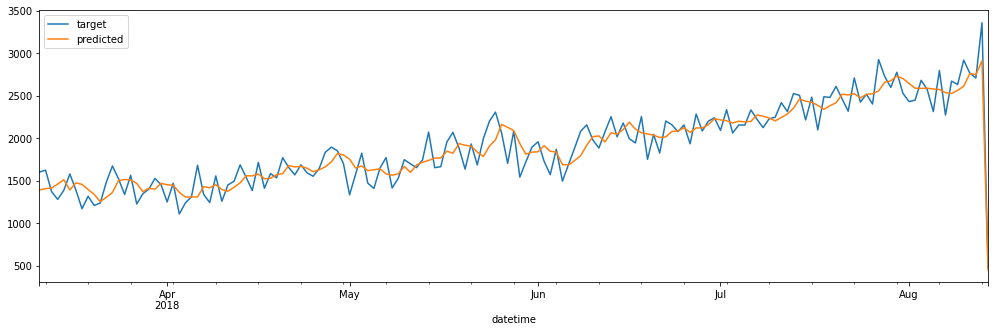

In [28]:
result = pd.DataFrame(index=target_train.index, columns=['target'])
result['target'] = target_train
result['predicted'] = predicted_train
result.resample('1D').sum().plot(figsize=(17,5))
plt.show()

На графике отчетливо видно, что модель достаточно точно следует за графиком реальных значений. Однако складывается впечатление, что модель отрабатывает с задержкой, предсказанные значения повторяют силуэт фактических, но со смещением.

Посмотрим на укрупненные данные, на тестовой выборке.

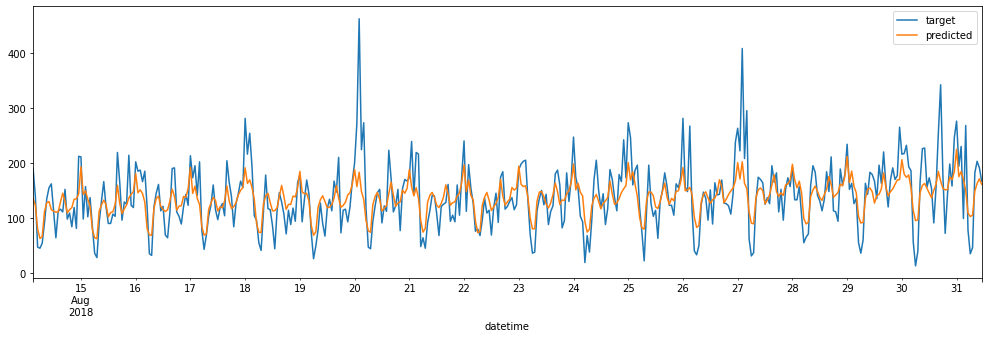

In [29]:
result = pd.DataFrame(index=target_test.index, columns=['target'])
result['target'] = target_test
result['predicted'] = predicted_test
result.plot(figsize=(17,5))
plt.show()

На укрупненной, тестовой выборке видно, что предсказанные значения более-менее точно следуют за фактическими. однако некоторый уровень дисперсии остается необъясненным, есть выбросы по часам, которые модель не может предсказать в точности. Возможно для уточнения модели можно каким-то образом идентифицировать выбросы и передавать модели данные, которые помогут определить потенциально экстремальное значение.

Для более внимательного анализа возьмем период из тестовой выборки. но короче.

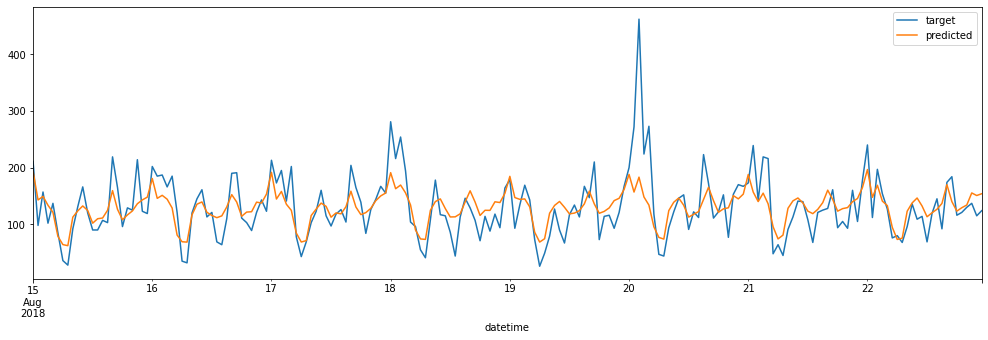

In [30]:
result = pd.DataFrame(index=target_test.index, columns=['target'])
result['target'] = target_test
result['predicted'] = predicted_test
result['2018-08-15':'2018-08-22'].plot(figsize=(17,5))
plt.show()

На этом графике еще лучше видно, что модель более-менее точно предсказывает реальные значения, однако ей не хватает точности.
Модель "мажет" в одних и тех же временых промежутках - а пиковые часы.

Возможно при добавлении в модель новых данных, которые могли бы объяснить выбросы, качество предсказания бы улучшилось.